<a href="https://colab.research.google.com/github/luigibonati/md-stateinterpreter/blob/main/analysis/notebooks/stateinterpreter_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Clone the entire repo.
!git clone https://github.com/luigibonati/md-stateinterpreter.git
%cd md-stateinterpreter
!ls
!pip install mdtraj
!pip install nglview
#Mount Google Drive
from google.colab import drive
drive.mount('/gdrive')
from google.colab import output
output.enable_custom_widget_manager()

In [71]:
%cd /content/md-stateinterpreter/
import stateinterpreter
from stateinterpreter.MD import Loader
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload
import nglview as nv
from stateinterpreter.classifier import MD_Data, CV_path
from stateinterpreter.plot import plot_cvpath, plot_states, plot_combination_cvs_relevant_features

/content/md-stateinterpreter


In [72]:
reload(stateinterpreter.MD)
reload(stateinterpreter.classifier)
reload(stateinterpreter.plot)

<module 'stateinterpreter.plot' from '/content/md-stateinterpreter/stateinterpreter/plot.py'>

# Loading of data

In [73]:
chignolin_data_path = '/gdrive/My Drive/MD_datasets/chignolin-unbiased/'
colvar_file = chignolin_data_path + 'COLVAR'
traj_dict = {
        'trajectory' : chignolin_data_path+'CLN025-0-protein-ALL.dcd',
        'topology' : chignolin_data_path+'CLN025-0-protein.pdb'
    }
# Compute descriptors from Trajectory
data = Loader(colvar_file, kbt=2.8, stride=100, _DEV=True)
data.load_trajectory(traj_dict)

Collective variables: (5248, 9)
Donors: [0, 15, 23, 36, 44, 70, 85, 91, 99, 106, 112, 120, 130, 147, 160]
Acceptors: [  0  15  22  23  36  43  44  52  53  55  56  69  70  81  82  84  85  91
  98  99 105 106 112 119 120 130 143 145 146 147 160]
Descriptors: (5248, 783)


### Example 1: single tICA component

In [74]:
cv_list = ['deep.node-4']
data.identify_states(cv_list, [(-1,1)], optimizer='brute', memory_saver=True)

100%|██████████| 50/50 [00:02<00:00, 21.73it/s]


Text(0, 0.5, 'Free energy surface [kJ/mol]')

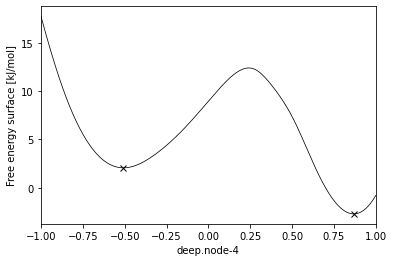

In [75]:
x = np.linspace(-1,1, 200)
plt.plot(x, data.fes(x), '-k', lw=0.75)
plt.plot(data.minima, data.fes(data.minima), 'kx')
plt.xlim(-1,1)
plt.xlabel(cv_list[0])
plt.ylabel("Free energy surface [kJ/mol]")

### Classifying the meta-stable states with minimal information concerning H-bonds

In [76]:
descriptors = data.collect_data()
descriptors.head(1)

,time,rmsd_ca,end,hbonds,deep.node-0,deep.node-1,deep.node-2,deep.node-3,deep.node-4,basin,selection,DIST. TYR1-CA -- TYR2-CA,DIST. TYR1-CA -- ASP3-CA,DIST. TYR1-CA -- PRO4-CA,DIST. TYR1-CA -- GLU5-CA,DIST. TYR1-CA -- THR6-CA,DIST. TYR1-CA -- GLY7-CA,DIST. TYR1-CA -- THR8-CA,DIST. TYR1-CA -- TRP9-CA,DIST. TYR1-CA -- TYR10-CA,DIST. TYR2-CA -- ASP3-CA,DIST. TYR2-CA -- PRO4-CA,DIST. TYR2-CA -- GLU5-CA,DIST. TYR2-CA -- THR6-CA,DIST. TYR2-CA -- GLY7-CA,DIST. TYR2-CA -- THR8-CA,DIST. TYR2-CA -- TRP9-CA,DIST. TYR2-CA -- TYR10-CA,DIST. ASP3-CA -- PRO4-CA,DIST. ASP3-CA -- GLU5-CA,DIST. ASP3-CA -- THR6-CA,DIST. ASP3-CA -- GLY7-CA,DIST. ASP3-CA -- THR8-CA,DIST. ASP3-CA -- TRP9-CA,DIST. ASP3-CA -- TYR10-CA,DIST. PRO4-CA -- GLU5-CA,DIST. PRO4-CA -- THR6-CA,DIST. PRO4-CA -- GLY7-CA,DIST. PRO4-CA -- THR8-CA,DIST. PRO4-CA -- TRP9-CA,...,HB_DIST GLY7-N -- TRP9-NE1s,HB_DIST GLY7-N -- TRP9-O,HB_DIST GLY7-N -- TYR10-O,HB_DIST GLY7-N -- TYR10-OXTs,HB_DIST GLY7-N -- TYR10-N,HB_DIST GLY7-N -- TYR10-OHs,HB_DIST GLY7-O -- THR8-N,HB_DIST GLY7-O -- THR8-OG1s,HB_DIST GLY7-O -- TRP9-N,HB_DIST GLY7-O -- TRP9-NE1s,HB_DIST GLY7-O -- TYR10-N,HB_DIST GLY7-O -- TYR10-OHs,HB_DIST THR8-N -- TRP9-N,HB_DIST THR8-N -- TRP9-NE1s,HB_DIST THR8-N -- TRP9-O,HB_DIST THR8-N -- TYR10-O,HB_DIST THR8-N -- TYR10-OXTs,HB_DIST THR8-N -- TYR10-N,HB_DIST THR8-N -- TYR10-OHs,HB_DIST THR8-OG1s -- TRP9-N,HB_DIST THR8-OG1s -- TRP9-NE1s,HB_DIST THR8-OG1s -- TRP9-O,HB_DIST THR8-OG1s -- TYR10-O,HB_DIST THR8-OG1s -- TYR10-OXTs,HB_DIST THR8-OG1s -- TYR10-N,HB_DIST THR8-OG1s -- TYR10-OHs,HB_DIST THR8-O -- TRP9-N,HB_DIST THR8-O -- TRP9-NE1s,HB_DIST THR8-O -- TYR10-N,HB_DIST THR8-O -- TYR10-OHs,HB_DIST TRP9-N -- TYR10-O,HB_DIST TRP9-N -- TYR10-OXTs,HB_DIST TRP9-N -- TYR10-N,HB_DIST TRP9-N -- TYR10-OHs,HB_DIST TRP9-NE1s -- TYR10-O,HB_DIST TRP9-NE1s -- TYR10-OXTs,HB_DIST TRP9-NE1s -- TYR10-N,HB_DIST TRP9-NE1s -- TYR10-OHs,HB_DIST TRP9-O -- TYR10-N,HB_DIST TRP9-O -- TYR10-OHs
0,0.0,0.067477,0.500523,3.515683,0.156591,0.269741,-0.503362,-0.76936,0.860714,1,True,0.382577,0.730466,0.997654,1.275664,1.293217,1.079655,0.913451,0.640626,0.500523,0.378884,0.634814,0.906806,0.922476,0.715209,0.612698,0.475651,0.531504,0.382201,0.552443,0.634502,0.564223,0.560408,0.662828,0.760802,0.38002,0.583246,0.500581,0.729261,0.895382,...,0.775358,0.888859,1.183446,1.226291,0.890513,0.776061,0.231385,0.447179,0.39599,0.444666,0.711082,0.813711,0.358486,0.616258,0.620017,0.949147,0.969916,0.641208,0.604746,0.443815,0.813649,0.623572,1.017308,0.99301,0.705949,0.452592,0.220587,0.555763,0.390153,0.554607,0.661815,0.644894,0.345168,0.595111,0.885089,0.906517,0.667443,1.068138,0.220265,0.584912


In [77]:
model = MD_Data(descriptors)

# Input features
select_feat = 'HB_CONTACT'
sample = model.sample(100, regex_filter = select_feat)

In [78]:
C_range = np.geomspace(1, 100, 25)
kwargs = {'LASSO':True, 'max_iter': 10000}
dset = sample.train_test_dataset()
n_examples = dset[0].shape[0]
C_range_in = C_range/n_examples
cvpath = CV_path(dset, sample.features, quadratic_kernel=False)

result = cvpath.compute(C_range_in,multi_class='ovr', **kwargs)

In [79]:
C = np.power(10,0.6)
#plot_cvpath(cvpath,C)

In [80]:
relevant_feat = cvpath.relevant_features(C)
unique_features = cvpath.unique_features(C)

print('\n-- RELEVANT FEATURES --')
cvpath.print_relevant_features(C)


-- RELEVANT FEATURES --
State 0:
	 75.5% | HB_CONTACT TYR1-O -- TYR10-N
	 24.5% | HB_CONTACT ASP3-N -- THR8-O
State 1:
	 75.5% | HB_CONTACT TYR1-O -- TYR10-N
	 24.5% | HB_CONTACT ASP3-N -- THR8-O


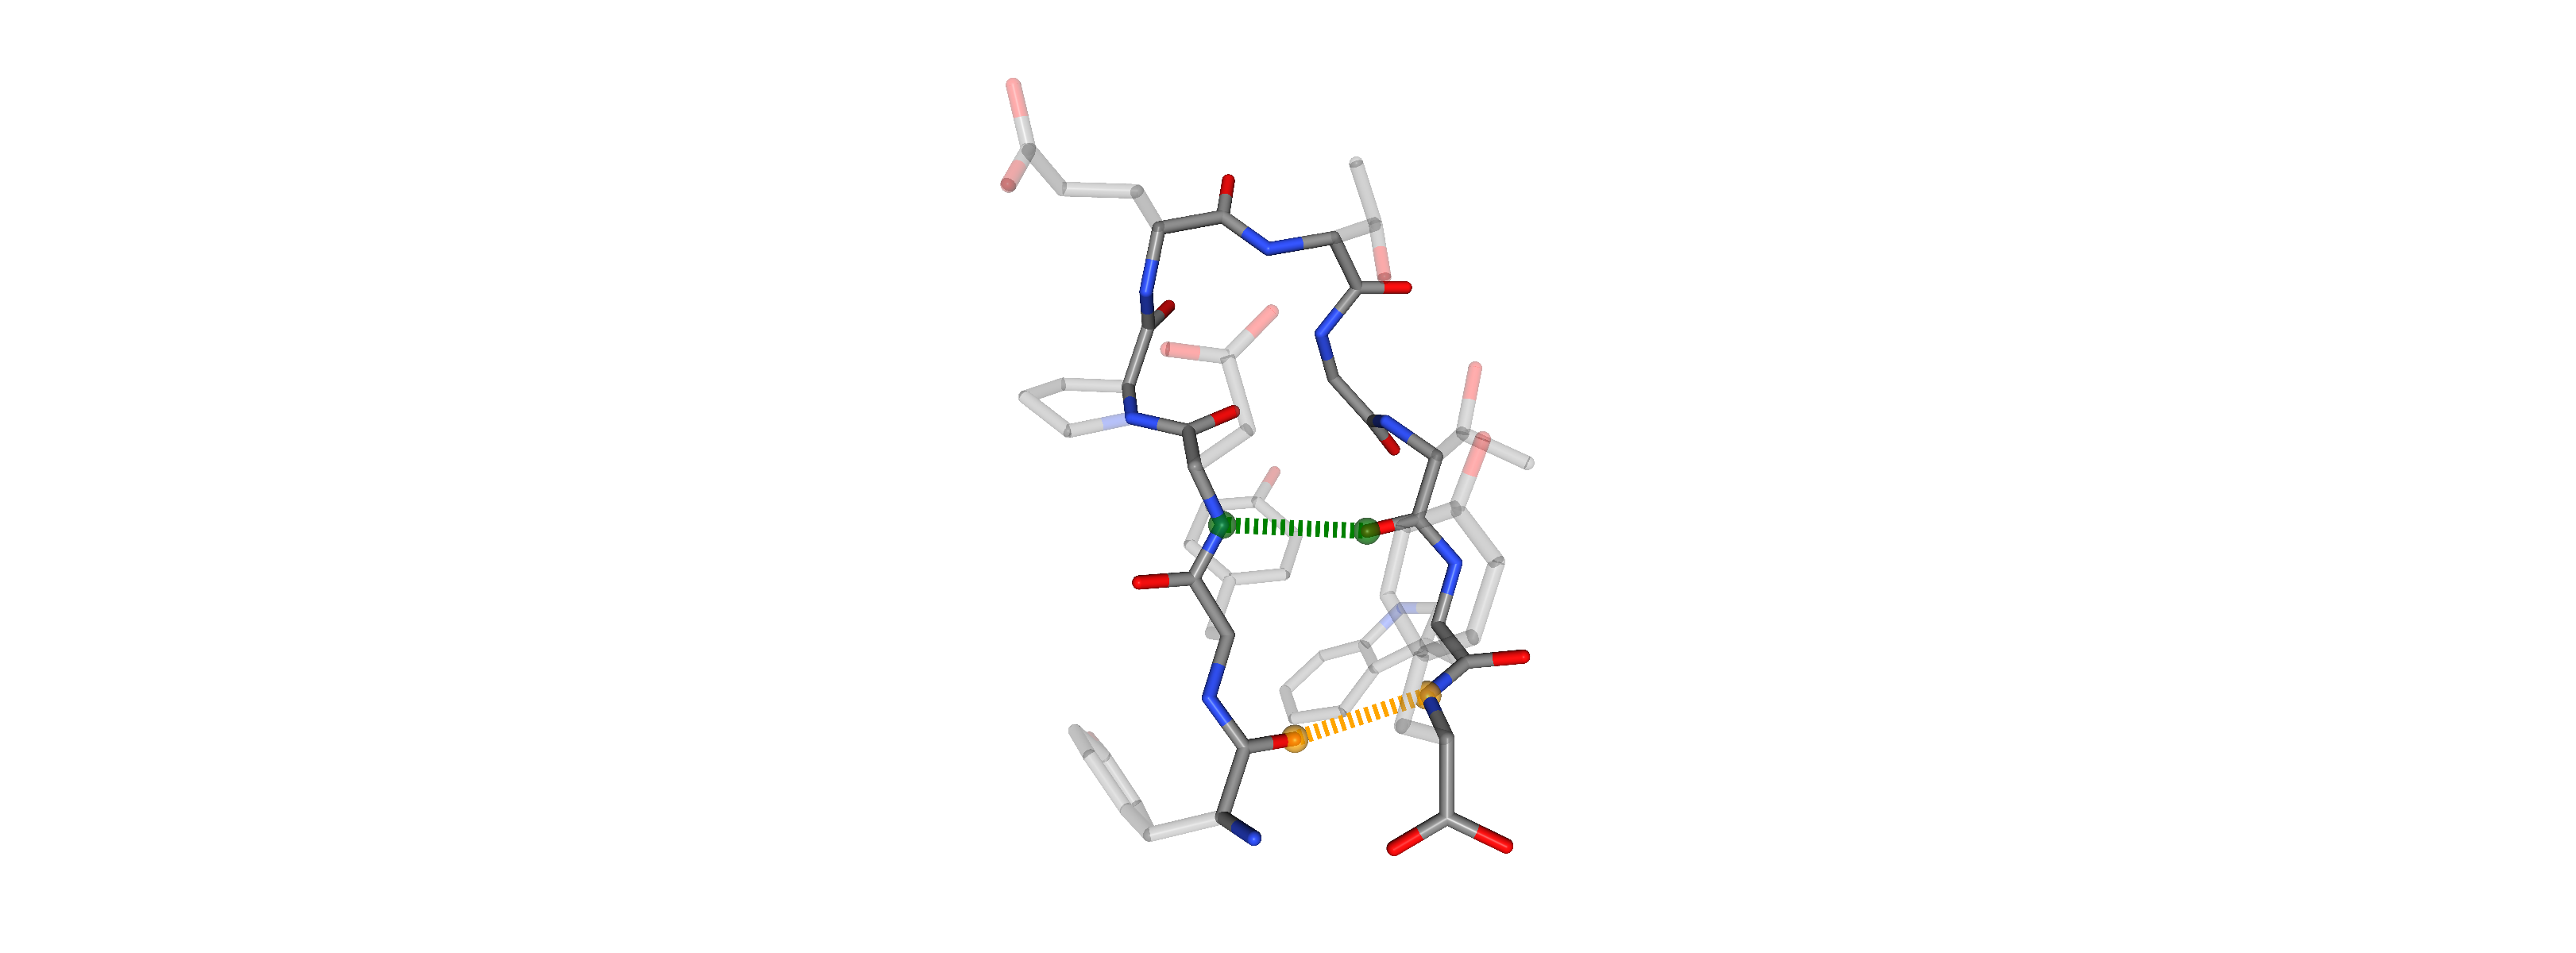

### Example 2: two tICA components

In [81]:
cv_list = ['deep.node-4', 'deep.node-3']
data.identify_states(cv_list, [(-1,1),(-1,1)], optimizer='brute', memory_saver=True)

100%|██████████| 50/50 [00:03<00:00, 14.55it/s]


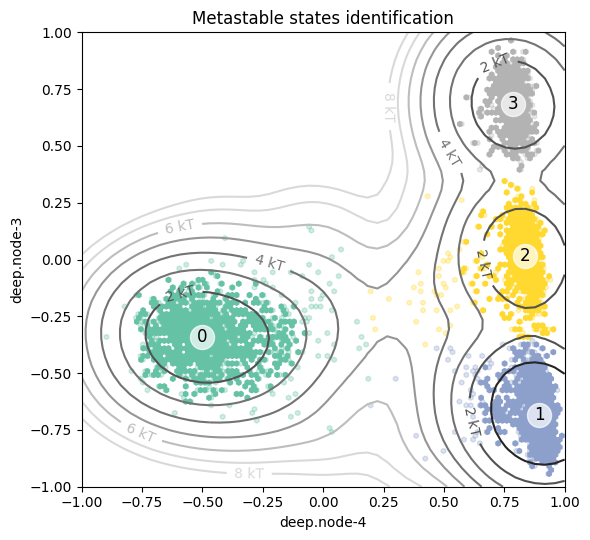

In [82]:
plot_states(data, fes_isolines=True)

In [83]:
descriptors = data.collect_data()
model = MD_Data(descriptors)
select_feat = 'sin_|cos_'
sample = model.sample(100, regex_filter = select_feat, states_subset=[1,2,3])

In [84]:
C_range = np.geomspace(1, 100, 25)
kwargs = {'LASSO':True, 'max_iter': 10000}
dset = sample.train_test_dataset()
n_examples = dset[0].shape[0]
C_range_in = C_range/n_examples
cvpath = CV_path(dset, sample.features, quadratic_kernel=False)

result = cvpath.compute(C_range_in,multi_class='ovr', **kwargs)


-- RELEVANT FEATURES --
State 0:
	 58.5% | SIDECHAIN sin_chi1 THR6
	 41.3% | SIDECHAIN cos_chi1 THR8
	 0.2%  | BACKBONE cos_psi THR8
State 1:
State 2:
	 51.5% | SIDECHAIN cos_chi1 THR8
	 48.5% | SIDECHAIN sin_chi1 THR6


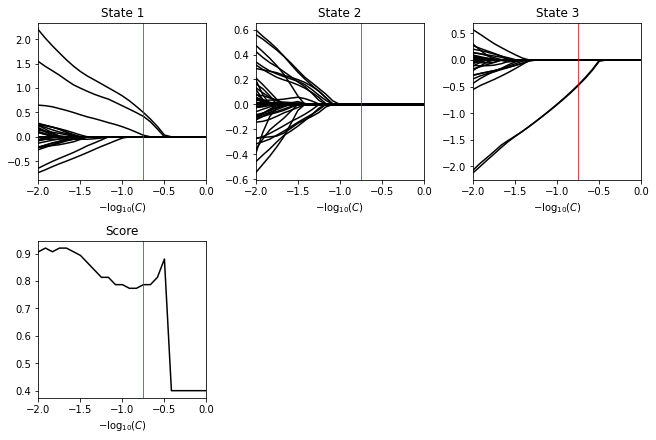

In [85]:
C = np.power(10,0.75)

# PLOT
print('\n-- RELEVANT FEATURES --')
cvpath.print_relevant_features(C)
plot_cvpath(cvpath,C);

In [86]:
prunedcv = cvpath.get_pruned_CVpath(C)
prunedcv.compute(C_range_in, **kwargs);


-- RELEVANT FEATURES --
State 0:
	 65.0% | SIDECHAIN sin_chi1 THR6
	 35.0% | SIDECHAIN cos_chi1 THR8
State 1:
	 100.0% | SIDECHAIN cos_chi1 THR8 || SIDECHAIN sin_chi1 THR6
State 2:
	 59.7% | SIDECHAIN cos_chi1 THR8
	 40.3% | SIDECHAIN sin_chi1 THR6


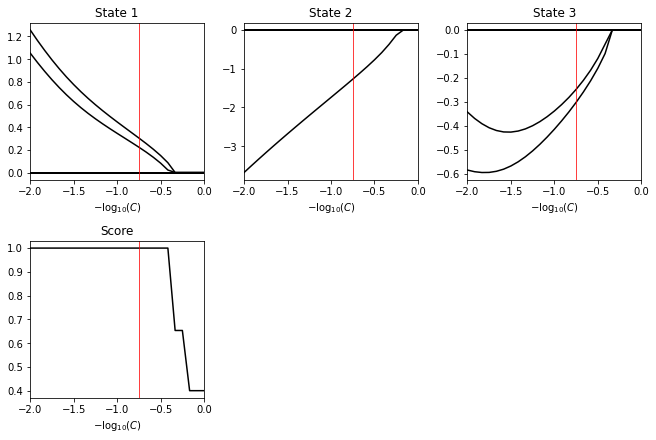

In [87]:
C = np.power(10,0.75)

# PLOT
plot_cvpath(prunedcv,C, state_names=[f'State {i + 1}' for i in range(3) ]);
print('\n-- RELEVANT FEATURES --')
prunedcv.print_relevant_features(C)

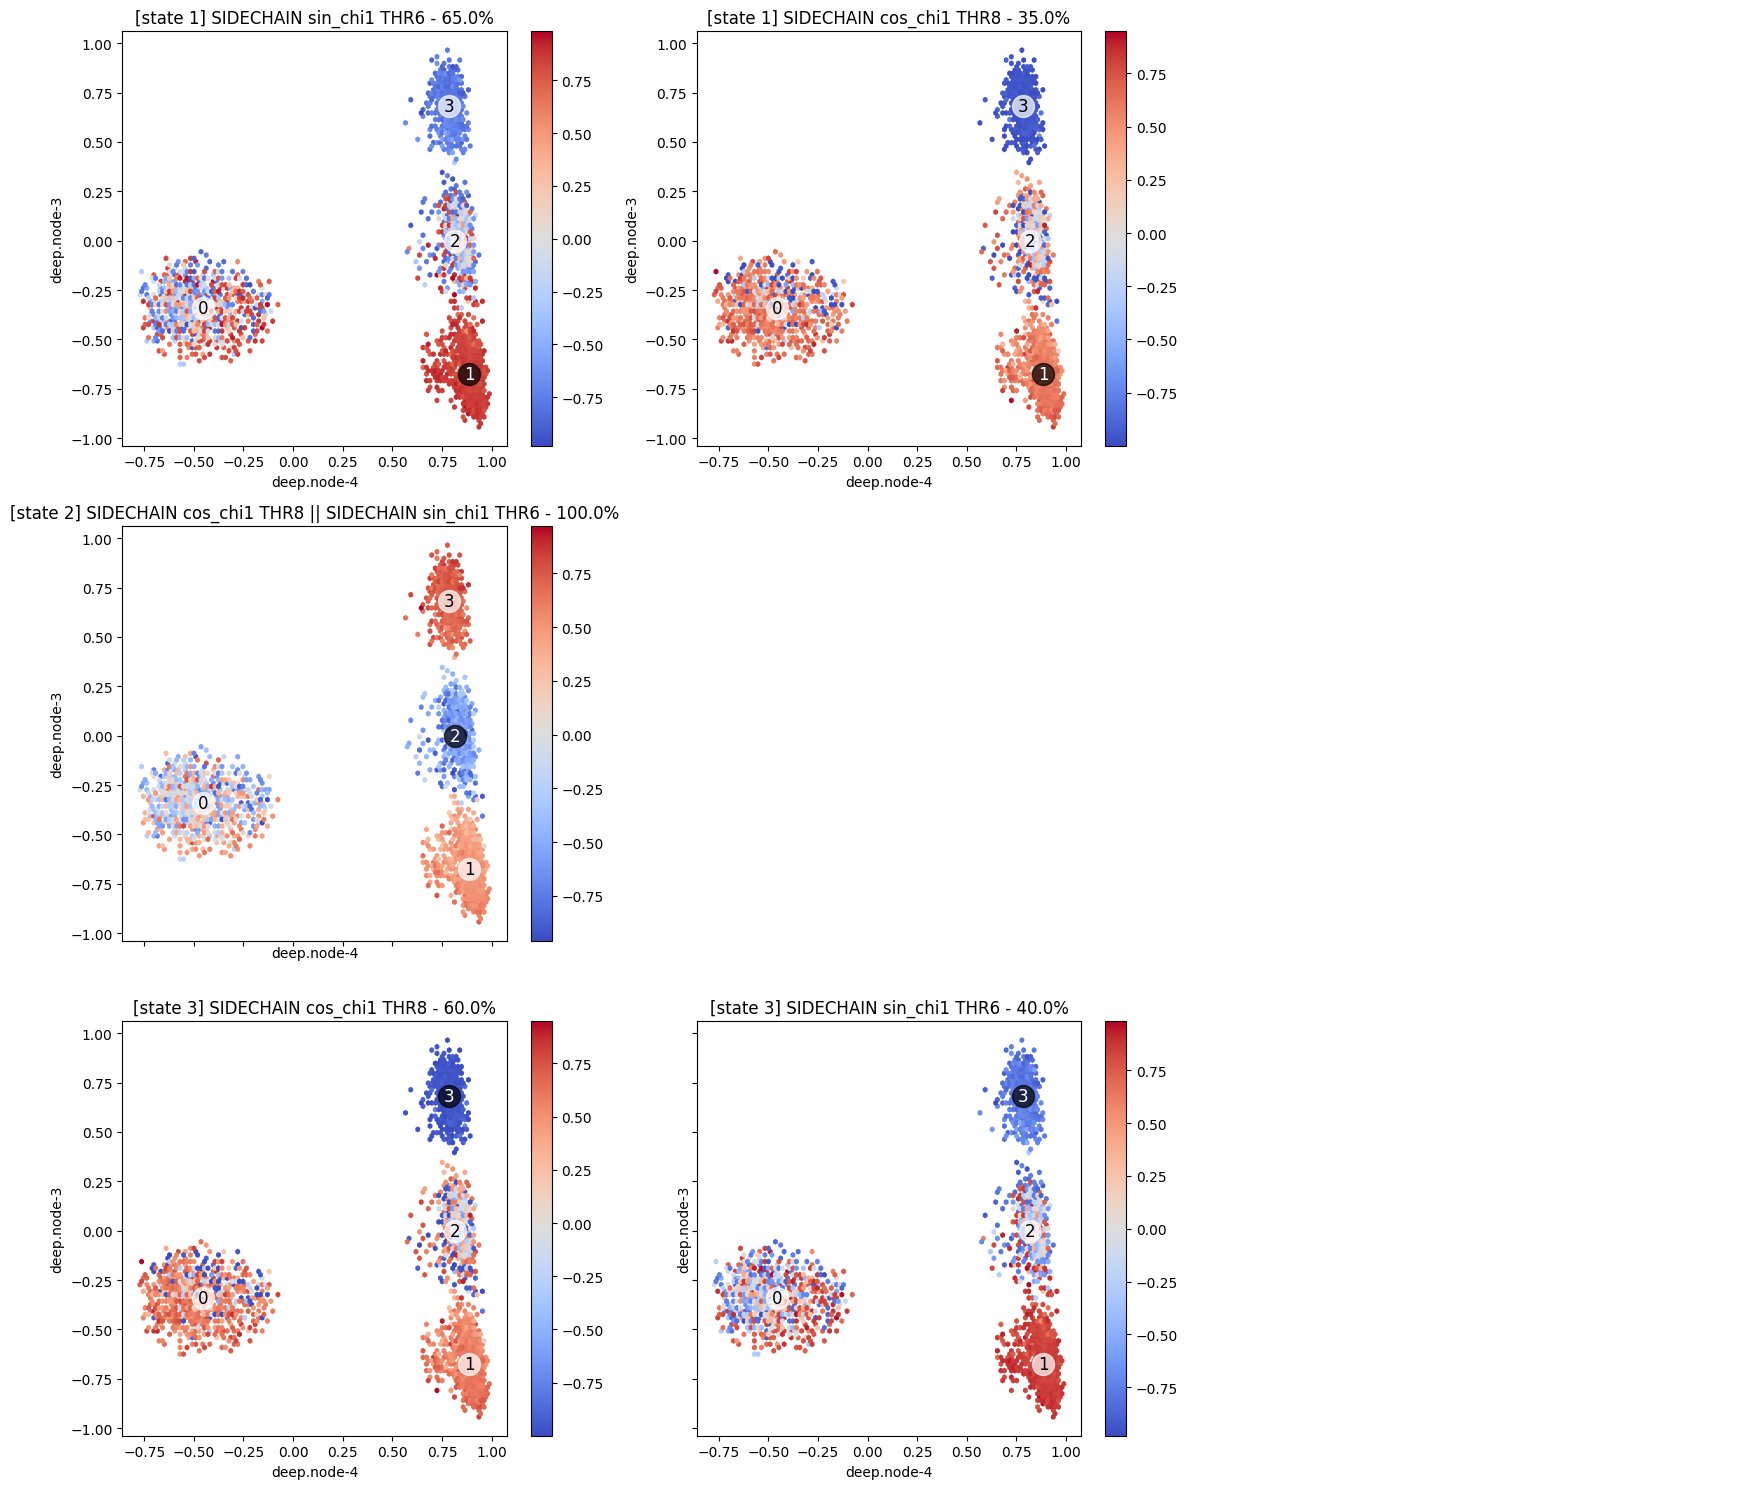

In [88]:
relevant_feat = prunedcv.relevant_features(C)
unique_features = prunedcv.unique_features(C)

plot_combination_cvs_relevant_features(descriptors,cv_list,relevant_feat)